### Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

opp = pd.read_excel('/Users/katew/Downloads/Copy of Ricoh_Opps_08022024.xlsx')

In [2]:
opp.columns = opp.columns.str.lower()
opp.columns

Index(['key', 'lead_number', 'opportunity_number', 'quote_number',
       'order_number', 'l2_rise_number', 'funnel_stage', 'lead_status_name',
       'lead_sub_source', 'lead_primary_product', 'customer_segment',
       'crm_industry', 'a4_bw_flag', 'a4_c_flag', 'a3_bw_flag', 'a3_c_flag',
       'docuware_flag', 'ransomcare_flag', 'it_health_check_flag', 'ms_flag',
       'pp_bw_cs_flag', 'pp_c_cs_flag', 'wf_bw_flag', 'wf_c_flag',
       'bw_lp_flag', 'color_lp_flag', 'mfp_flag', 'mindshift_flag',
       'lead_date', 'opp_date', 'opp_rev', 'quote_date', 'quote_rev',
       'order_date', 'order_rev', 'close_date', 'sales_stage_status', 'closed',
       'has_lead', 'start_date', 'open_days', 'close_days', 'win', 'rev',
       'eloqua', 'eloqua oc', 'lead', 'opp', 'order', 'quote', 'sales', 'web',
       'webinar', 'cs', 'hw', 'its', 'ms off', 'ms on', 'ps', 'refi', 'rent',
       'supp', 'ts', 'svc_calls', 'cv', 'mif', 'renewal', 'sat', 'nps',
       'department', 'job_type', 'employees

In [3]:
import seaborn as sns
import squarify
import statsmodels.api as sm
from tabulate import tabulate
import warnings
from functools import reduce
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

%matplotlib inline 

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)

In [4]:
def na_check(df, na_only = True): 
    na = df.isna().mean()*100
    if na_only == False:
        print(na)
    else:
        print(na[na>0])

def plot_2d(x, dim_method, cluster_method, label):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(x[:, 0], x[:, 1], c=label, cmap='viridis', s=50, alpha=0.6)
    plt.colorbar(scatter)
    plt.title(f'{cluster_method} Clusters on {dim_method} Reduced Data')
    plt.xlabel(f'{dim_method} Axis 1')
    plt.ylabel(f'{dim_method} Axis 2')
    plt.show()

def plot_2d_cat(x, dim_method, cluster_method, label):
    label_codes = pd.Categorical(label).codes
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(x[:, 0], x[:, 1], c=label_codes, cmap='viridis', s=50, alpha=0.6)
    plt.colorbar(scatter, ticks=range(len(pd.unique(label))), label='Cluster Labels')
    plt.title(f'{cluster_method} Clusters on {dim_method} Reduced Data')
    plt.xlabel(f'{dim_method} Axis 1')
    plt.ylabel(f'{dim_method} Axis 2')
    plt.show()

def plot_3d(x, dim_method, cluster_method, label):
    
    trace = go.Scatter3d(
        x=x[:, 0],
        y=x[:, 1],
        z=x[:, 2],
        mode='markers',
        marker=dict(
            size=1,
            color=label,  # Assign a unique color to each point for better visualization
            colorscale='Viridis',  # Color scale to use
            opacity=0.8
        )
    )
    
    # Creating the layout
    layout = go.Layout(
        margin=dict(l=0, r=0, b=0, t=0),
        title=f'3D {dim_method} - {cluster_method} Visualization',
        scene=dict(
            xaxis=dict(title=f'{dim_method} Axis 1'),
            yaxis=dict(title=f'{dim_method} Axis 2'),
            zaxis=dict(title=f'{dim_method} Axis 3')
        )
    )
    fig = go.Figure(data=[trace], layout=layout)
    fig.show()

In [5]:
# categorize
print(opp.columns.get_loc("eloqua"))
print(opp.columns.get_loc("webinar"))
print(opp.columns.get_loc("sat"))
print(opp.columns.get_loc("cs"))
print(opp.columns.get_loc("renewal"))
eng_cols = opp.columns[44:53].tolist()
sat_cols = opp.columns[67:69].tolist()
key_cols = ['key', 'opportunity_number', 'lead_number', 'quote_number', 'order_number', 'l2_rise_number']
cat_cols = opp.select_dtypes(include=['object']).columns
inv_cols = opp.columns[53:67].tolist()
flag_cols = [col for col in opp.columns if "flag" in col]
rev_cols = [col for col in opp.columns if 'rev' in col]
dt_cols = [col for col in opp.columns if 'date' in col]

44
52
67
53
66


### TOP 10 lead closed deals

In [14]:
for col in eng_cols:
    opp[col] = opp[col].fillna(0)
    
for col in sat_cols:
    opp[col] = opp[col].fillna(opp[col].mean())
    
for col in inv_cols:
    opp[col] = opp[col].fillna(0)

In [21]:
opp['has_lead'] = opp['lead_number'].notna().astype(int)
opp_lead = opp[opp.has_lead == 1]

# Closed is 1
closed_orders = opp_lead[opp_lead['closed'] == 1]

# select the top 10 lead closed
top_10_closed_lead_rev = closed_orders.sort_values(by='order_rev', ascending=False).head(10)
print(top_10_closed_lead_rev)

               key   lead_number opportunity_number  quote_number  \
291   L-1000582771  L-1000582771       O-1001442727    29647448.0   
4373  L-1000498256  L-1000498256       O-1000286653    29879949.0   
5742  L-1000639317  L-1000639317       O-1002377379    33708190.0   
5929  L-1000615748  L-1000615748       O-1002033032    33386564.0   
6180  L-1000493825  L-1000493825       O-1000797582    27457978.0   
6310  L-1000643652  L-1000643652       O-1002276839    32836124.0   
7369  L-1000812227  L-1000812227       O-1002440803    33568255.0   
8124  L-1000610622  L-1000610622       O-1002032837    31898059.0   
8132  L-1000622994  L-1000622994       O-1001738101    33554405.0   
8199  L-1000812053  L-1000812053       O-1002483194    33362262.0   

      order_number l2_rise_number funnel_stage lead_status_name  \
291     80625966.0   A-0013760889          SQL        Converted   
4373    79763925.0   A-0013550499          SQL        Converted   
5742   105031989.0     O-39721614      

In [16]:
print(top_10_closed_lead_rev.isna().sum())

key                     0
lead_number             0
opportunity_number      0
quote_number            0
order_number            0
l2_rise_number          0
funnel_stage            0
lead_status_name        0
lead_sub_source         1
lead_primary_product    0
customer_segment        0
crm_industry            0
a4_bw_flag              0
a4_c_flag               0
a3_bw_flag              0
a3_c_flag               0
docuware_flag           0
ransomcare_flag         0
it_health_check_flag    0
ms_flag                 0
pp_bw_cs_flag           0
pp_c_cs_flag            0
wf_bw_flag              0
wf_c_flag               0
bw_lp_flag              0
color_lp_flag           0
mfp_flag                0
mindshift_flag          0
lead_date               0
opp_date                0
opp_rev                 0
quote_date              0
quote_rev               0
order_date              0
order_rev               0
close_date              0
sales_stage_status      0
closed                  0
has_lead    

### 9 NAs in sat and nps, 2 in cs/hw/its/ms off/ms on/ps/refi/rent/supp/ts/servical calls/cv/mif/renewal

Explained Variance for 3 components: 87.23%
Top contributing features for each component:
    a4_bw_flag     a4_c_flag  a3_bw_flag  a3_c_flag  docuware_flag  \
0   -0.084255  1.110223e-16   -0.049454  -0.047644  -4.336809e-19   
1    0.049969  2.775558e-17    0.030516  -0.217174  -0.000000e+00   
2   -0.469949  9.714451e-17   -0.428626  -0.405045   3.330669e-16   

   ransomcare_flag  it_health_check_flag       ms_flag  pp_bw_cs_flag  \
0    -1.355253e-20         -4.235165e-22 -6.617445e-24       0.198373   
1     2.710505e-20         -2.541099e-21  2.646978e-23      -0.182408   
2     0.000000e+00          0.000000e+00  2.710505e-20       0.045884   

   pp_c_cs_flag  svc_calls        cv       mif   renewal       sat       nps  \
0      0.084255   0.308861  0.231662  0.301136  0.170512 -0.039562 -0.039562   
1     -0.049969   0.012994 -0.257714  0.089520 -0.035664  0.398364  0.398364   
2      0.469949  -0.056386 -0.077134 -0.049451 -0.380140 -0.007883 -0.007883   

   employees_dnb  

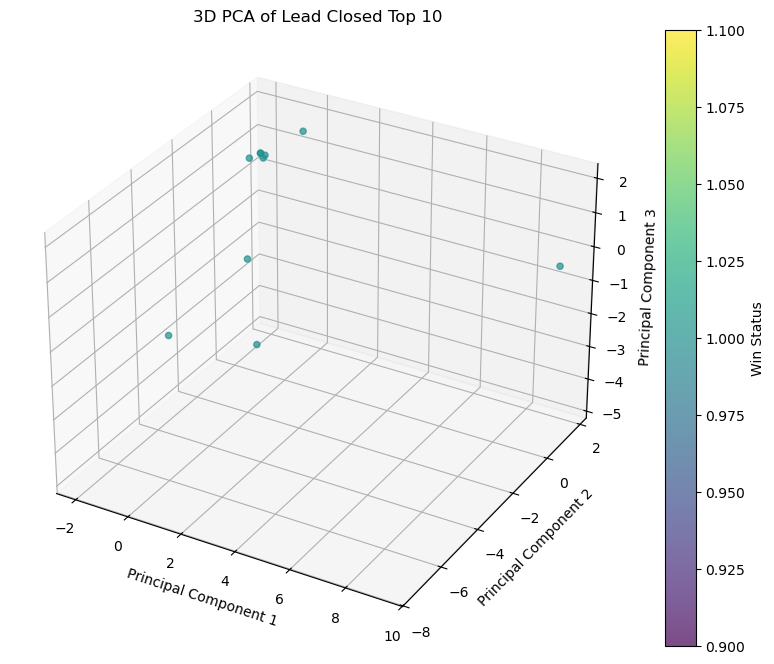

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Product flags and metrics
product_flags = ['a4_bw_flag', 'a4_c_flag', 'a3_bw_flag', 'a3_c_flag', 
                 'docuware_flag', 'ransomcare_flag', 'it_health_check_flag', 
                 'ms_flag', 'pp_bw_cs_flag', 'pp_c_cs_flag']
metrics = ['svc_calls', 'cv', 'mif', 'renewal', 'sat', 'nps', 
           'employees_dnb', 'sales_dnb', 'web', 'webinar', 
           'cs', 'hw', 'its', 'ms off', 'ms on', 'ps', 'refi', 'rent', 
           'supp', 'ts']

# One-hot encode categorical variables
categorical_col = ['customer_segment', 'crm_industry', 'sales_stage_status', 'funnel_stage']
top_10_closed_lead_rev = pd.get_dummies(top_10_closed_lead_rev, columns=categorical_col)

# Select features for PCA
data = top_10_closed_lead_rev[product_flags + metrics]

# Scale features (excluding 'win'), win will be scaled as "nan"
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca = PCA(n_components=3)
pca_data = pca.fit_transform(data_scaled)

pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2', 'PC3'])

# Add 'win' back to the PCA DataFrame
pca_df['win'] = top_10_closed_lead_rev['win'].values

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], 
                     c=pca_df['win'], cmap='viridis', alpha=0.7)

explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained Variance for 3 components: {explained_variance * 100:.2f}%")

components_df = pd.DataFrame(pca.components_, columns=product_flags + metrics)
print("Top contributing features for each component:\n", components_df)

plt.colorbar(scatter, label='Win Status')
ax.set_title('3D PCA of Lead Closed Top 10')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.show()

#### Exclude supp, its, ms off, a4_bw_flag and pp_bw_cs_flag

Explained Variance for 3 components: 91.73%
Top contributing features for each component:
       a4_c_flag  a3_bw_flag  a3_c_flag  docuware_flag  ransomcare_flag  \
0 -2.081668e-17   -0.037673  -0.052849   2.775558e-17    -8.673617e-19   
1  0.000000e+00    0.016993   0.316046  -1.387779e-17     8.673617e-19   
2 -5.551115e-17    0.540813   0.407671  -1.110223e-16    -4.163336e-17   

   it_health_check_flag       ms_flag  pp_c_cs_flag  svc_calls        cv  \
0          0.000000e+00  1.323489e-23      0.068579   0.316122  0.218324   
1          6.776264e-21  0.000000e+00      0.007578   0.030100  0.355276   
2          2.168404e-19 -3.388132e-21     -0.535565   0.029028  0.013794   

        mif   renewal  employees_dnb  sales_dnb       web   webinar        cs  \
0  0.313610  0.179643       0.244205   0.305144  0.264652 -0.013455  0.312668   
1 -0.066165  0.117911      -0.096027  -0.090044  0.273459  0.449123 -0.072495   
2  0.035026  0.436969      -0.052116  -0.030072 -0.058341 -0.142

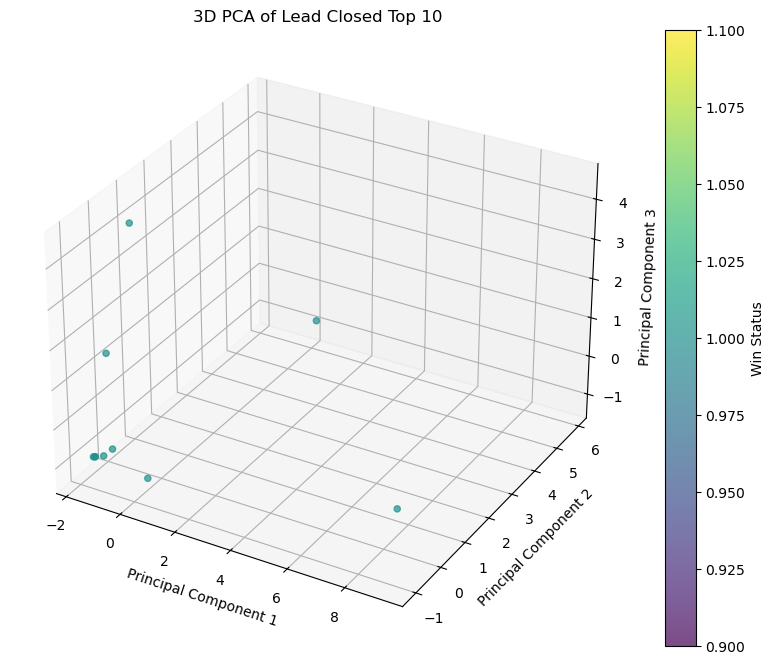

In [22]:
# Product flags and metrics
product_flags = [ 'a4_c_flag', 'a3_bw_flag', 'a3_c_flag', 
                 'docuware_flag', 'ransomcare_flag', 'it_health_check_flag', 
                 'ms_flag', 'pp_c_cs_flag']
metrics = ['svc_calls', 'cv', 'mif', 'renewal',
           'employees_dnb', 'sales_dnb', 'web', 'webinar', 
           'cs', 'hw', 'ms on', 'ps', 'refi', 'rent', 
            'ts']

# One-hot encode categorical variables
categorical_col = ['customer_segment', 'crm_industry', 'sales_stage_status', 'funnel_stage']
top_10_closed_lead_rev = pd.get_dummies(top_10_closed_lead_rev, columns=categorical_col)

# Select features for PCA
data = top_10_closed_lead_rev[product_flags + metrics]

# Scale features (excluding 'win'), win will be scaled as "nan"
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca = PCA(n_components=3)
pca_data = pca.fit_transform(data_scaled)

pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2', 'PC3'])

# Add 'win' back to the PCA DataFrame
pca_df['win'] = top_10_closed_lead_rev['win'].values

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], 
                     c=pca_df['win'], cmap='viridis', alpha=0.7)

explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained Variance for 3 components: {explained_variance * 100:.2f}%")

components_df = pd.DataFrame(pca.components_, columns=product_flags + metrics)
print("Top contributing features for each component:\n", components_df)

plt.colorbar(scatter, label='Win Status')
ax.set_title('3D PCA of Lead Closed Top 10')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.show()

### Component 1 is influenced by svc_calls, mif, employees_dnb, sales_dnb, web, cs, and flags like ms_on; Component 2 shows high loadings for webinar, ps, refi, rent; Component 3 is impacted by a3_bw_flag, a3_c_flag, pp_c_cs_flag, and features like renewal

### top 10 order_rev closed deals (many N/A in sat and nps, cs, webinar, its,ms off, rent,refi, might consider exclude those)

In [49]:
# fix numeric by parts
# impute engagement to 0, this is stats about past stuff, should be here, if not just 0 
for col in eng_cols:
    opp[col] = opp[col].fillna(0)

# impute inv to 0; checked if order_date na, no inv anyways
for col in inv_cols:
    opp[col] = opp[col].fillna(0)

# impute flag with mean for now: a probabilty assigned to a more general population, try knn 
# only missing when it's a lead, so just use a mean, 
for col in flag_cols:
    opp[col] = opp[col].fillna(opp[col].mean())

for col in sat_cols:
    opp[col] = opp[col].fillna(opp[col].mean())

for col in ['employees_dnb', 'sales_dnb']:
    opp[col] = opp[col].fillna(0)
#impute_cols = ["employees_dnb","sales_dnb"]  # need more l2 related cols to do this, but skip for now
#imputer = KNNImputer(n_neighbors = 5)
#opp[impute_cols] = imputer.fit_transform(opp[impute_cols])

In [48]:
# 1. filter based on problem of interest

# remove missing l2 - remove for general purpose
opp = opp[opp.l2_rise_number.notnull()]

# closed deals for now
opp = opp[opp.closed == 1].drop(['closed'], axis = 1)

# 2. type conversion

opp['quote_number'] = opp['quote_number'].apply(lambda x: str(int(x)) if pd.notna(x) else np.nan)
opp['order_number'] = opp['order_number'].apply(lambda x: str(int(x)) if pd.notna(x) else np.nan)

for col_name in dt_cols: 
    opp[col_name] = pd.to_datetime(opp[col_name])


# 3. clean up string col format

# Remove trailing white spaces for char cols (department has trailing white spaces, so just clean all) 
num_cols = opp.select_dtypes(include=['number']).columns
cat_cols = opp.select_dtypes(include=['object']).columns
opp[cat_cols] = opp[cat_cols].apply(lambda x: x.str.rstrip())

# 4. fix NAs not effected by lead/opp type
# treat missing quote and order revenues as 0, probably is actual 0.
opp['quote_rev'].fillna(0, inplace = True)
opp['order_rev'].fillna(0, inplace = True)

# 5.
# add a opportunity ind
opp['has_opp'] = opp['opportunity_number'].notna().astype(int)

In [46]:
# Closed is 1
closed_orders = opp[opp['closed'] == 1]

# select the top 10
top_10_closed_order_rev = closed_orders.sort_values(by='order_rev', ascending=False).head(10)
print(top_10_closed_order_rev)

               key   lead_number opportunity_number  quote_number  \
263   O-1002196655           NaN       O-1002196655    32593918.0   
279   O-1002799978           NaN       O-1002799978    34527867.0   
291   L-1000582771  L-1000582771       O-1001442727    29647448.0   
339   O-1001959650           NaN       O-1001959650    31678470.0   
691   O-1001874940           NaN       O-1001874940    31433488.0   
1249  O-1002361742           NaN       O-1002361742    33034982.0   
1445  O-1000681686           NaN       O-1000681686    28970530.0   
1469  O-1001463256           NaN       O-1001463256    29613583.0   
1483  O-1001426947           NaN       O-1001426947    31734073.0   
1502  O-1002510774           NaN       O-1002510774    33447098.0   

      order_number l2_rise_number funnel_stage lead_status_name  \
263    102968429.0   A-1006056777          SQL              NaN   
279    106408334.0   A-1003108403          SQL              NaN   
291     80625966.0   A-0013760889      

In [19]:
print(top_10_closed_order_rev.isna().sum())

key                     0
lead_number             9
opportunity_number      0
quote_number            0
order_number            0
l2_rise_number          0
funnel_stage            0
lead_status_name        9
lead_sub_source         9
lead_primary_product    9
customer_segment        0
crm_industry            0
a4_bw_flag              0
a4_c_flag               0
a3_bw_flag              0
a3_c_flag               0
docuware_flag           0
ransomcare_flag         0
it_health_check_flag    0
ms_flag                 0
pp_bw_cs_flag           0
pp_c_cs_flag            0
wf_bw_flag              0
wf_c_flag               0
bw_lp_flag              0
color_lp_flag           0
mfp_flag                0
mindshift_flag          0
lead_date               9
opp_date                0
opp_rev                 0
quote_date              0
quote_rev               0
order_date              0
order_rev               0
close_date              0
sales_stage_status      0
closed                  0
has_lead    

### TOP 10 Order_rev closed deals PCA

Explained Variance for 3 components: 67.99%
Top contributing features for each component:
    a4_bw_flag  a4_c_flag  a3_bw_flag  a3_c_flag  docuware_flag  \
0   -0.047155  -0.047155    0.223021   0.191132       0.088638   
1   -0.002780  -0.002780    0.056788  -0.263280      -0.029762   
2   -0.258691  -0.258691    0.057488  -0.018290       0.449299   

   ransomcare_flag  it_health_check_flag   ms_flag  pp_bw_cs_flag  \
0    -2.168404e-19         -2.710505e-20  0.010248       0.235199   
1     1.387779e-17         -6.938894e-18  0.013911      -0.279638   
2     1.665335e-16         -5.551115e-17  0.386140       0.149800   

   pp_c_cs_flag  svc_calls        cv       mif   renewal       sat       nps  \
0      0.091519   0.337608  0.329087  0.093986  0.257141  0.031909  0.032230   
1     -0.159369   0.024307  0.009358  0.166405  0.105577  0.420495  0.420773   
2     -0.321469   0.000855  0.104072  0.043276  0.238235  0.022409  0.022254   

   employees_dnb  sales_dnb       web   webina

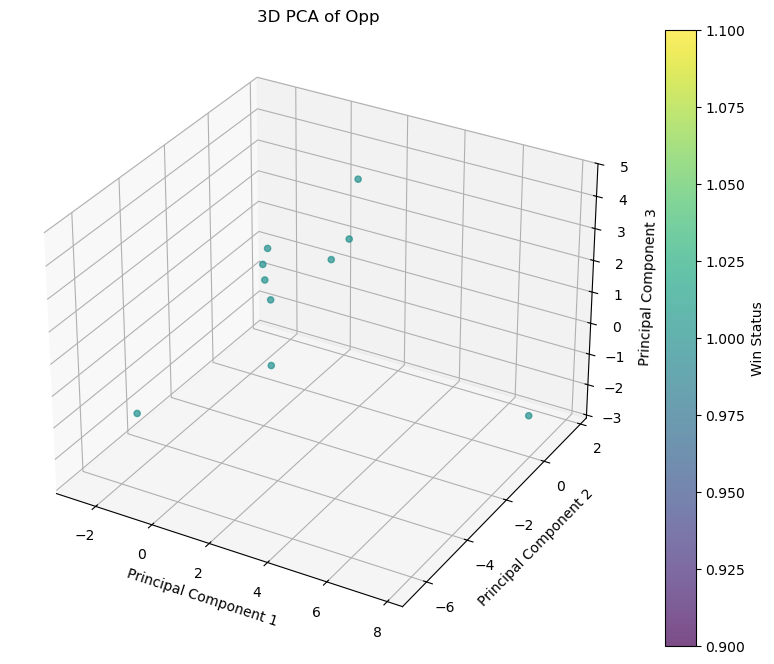

In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Product flags and metrics
product_flags = ['a4_bw_flag', 'a4_c_flag', 'a3_bw_flag', 'a3_c_flag', 
                 'docuware_flag', 'ransomcare_flag', 'it_health_check_flag', 
                 'ms_flag', 'pp_bw_cs_flag', 'pp_c_cs_flag']
metrics = ['svc_calls', 'cv', 'mif', 'renewal', 'sat', 'nps', 
           'employees_dnb', 'sales_dnb', 'web', 'webinar', 
           'cs', 'hw', 'its', 'ms off', 'ms on', 'ps', 'refi', 'rent', 
           'supp', 'ts']

# One-hot encode categorical variables
categorical_col = ['customer_segment', 'crm_industry', 'sales_stage_status', 'funnel_stage']
top_10_closed_order_rev = pd.get_dummies(top_10_closed_order_rev, columns=categorical_col)

# Select features for PCA
data = top_10_closed_order_rev[product_flags + metrics]

# Scale features (excluding 'win'), win will be scaled as "nan"
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca = PCA(n_components=3)
pca_data = pca.fit_transform(data_scaled)

pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2', 'PC3'])

# Add 'win' back to the PCA DataFrame
pca_df['win'] = top_10_closed_order_rev['win'].values

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], 
                     c=pca_df['win'], cmap='viridis', alpha=0.7)

explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained Variance for 3 components: {explained_variance * 100:.2f}%")

components_df = pd.DataFrame(pca.components_, columns=product_flags + metrics)
print("Top contributing features for each component:\n", components_df)

plt.colorbar(scatter, label='Win Status')
ax.set_title('3D PCA of Opp')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.show()

#### PC1: svc_calls (0.338), cv (0.329), pp_bw_cs_flag (0.235), and ms off (0.306); PC2: sat (0.420), nps (0.421), and webinar (-0.416); PC3: docuware_flag (0.449), ms_flag (0.386), and web (0.424), May consider exclude: sat, nps, cs, webinar, its,ms off, rent,refi

Explained Variance for 3 components: 69.74%
Top contributing features for each component:
    a4_bw_flag  a4_c_flag  a3_bw_flag  a3_c_flag  docuware_flag  \
0   -0.052529  -0.052529    0.239310   0.217276       0.116376   
1    0.396820   0.396820    0.061424   0.147379      -0.357628   
2    0.300948   0.300948    0.197287   0.366752       0.343736   

   ransomcare_flag  it_health_check_flag   ms_flag  pp_bw_cs_flag  \
0     2.710505e-20         -3.388132e-21  0.024217       0.266666   
1     8.326673e-17         -0.000000e+00 -0.333004      -0.102225   
2     5.551115e-17         -0.000000e+00  0.278501       0.195058   

   pp_c_cs_flag  svc_calls        cv   renewal  employees_dnb  sales_dnb  \
0      0.095116   0.348527  0.345747  0.277850      -0.123205  -0.117527   
1      0.368800   0.011649 -0.071186 -0.205364      -0.062479  -0.118976   
2      0.023652  -0.063221  0.024789 -0.040724      -0.222234  -0.265568   

        web        hw  its     ms on        ps      supp      

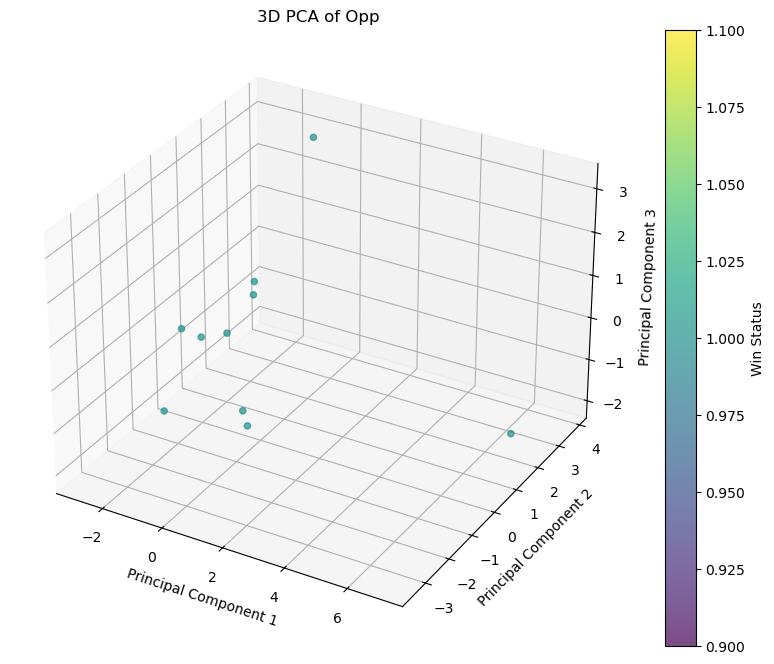

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Product flags and metrics
product_flags = ['a4_bw_flag', 'a4_c_flag', 'a3_bw_flag', 'a3_c_flag', 
                 'docuware_flag', 'ransomcare_flag', 'it_health_check_flag', 
                 'ms_flag', 'pp_bw_cs_flag', 'pp_c_cs_flag']
metrics = ['svc_calls', 'cv', 'renewal', 
           'employees_dnb', 'sales_dnb', 'web', 
            'hw', 'its', 'ms on', 'ps', 
           'supp', 'ts','mif']

# One-hot encode categorical variables
categorical_col = ['customer_segment', 'crm_industry', 'sales_stage_status', 'funnel_stage']
top_10_closed_order_rev = pd.get_dummies(top_10_closed_order_rev, columns=categorical_col)

# Select features for PCA
data = top_10_closed_order_rev[product_flags + metrics]

# Scale features (excluding 'win'), win will be scaled as "nan"
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca = PCA(n_components=3)
pca_data = pca.fit_transform(data_scaled)

pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2', 'PC3'])

# Add 'win' back to the PCA DataFrame
pca_df['win'] = top_10_closed_order_rev['win'].values

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], 
                     c=pca_df['win'], cmap='viridis', alpha=0.7)

explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained Variance for 3 components: {explained_variance * 100:.2f}%")

components_df = pd.DataFrame(pca.components_, columns=product_flags + metrics)
print("Top contributing features for each component:\n", components_df)

plt.colorbar(scatter, label='Win Status')
ax.set_title('3D PCA of Opp Top 10 closed deals')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.show()

#### PC1: svc_calls (0.349), cv (0.346), renewal (0.278), and flags like pp_bw_cs_flag (0.267), ms on (0.305) a3_bw_flag (0.239) and a3_c_flag (0.217); PC2: 4_bw_flag and a4_c_flag (both 0.397), docuware_flag (-0.358), and ms_flag (-0.333); PC3: a3_c_flag (0.367), docuware_flag (0.344), ms_flag (0.279), and a4_bw_flag and a4_c_flag (both around 0.301).  its, mif, ransomcare_flag and it_health_check_flag minimal influence.

Explained Variance for 3 components: 72.48%
Top contributing features for each component:
    a4_bw_flag  a4_c_flag  a3_bw_flag  a3_c_flag  docuware_flag   ms_flag  \
0   -0.049044  -0.049044    0.241775   0.225404       0.120266  0.028807   
1   -0.351896  -0.351896   -0.033803  -0.090309       0.404227  0.372064   
2    0.373066   0.373066    0.217343   0.353174       0.277116  0.201479   

   pp_bw_cs_flag  pp_c_cs_flag  svc_calls        cv   renewal  employees_dnb  \
0       0.273073      0.092723   0.351245  0.349229  0.271503      -0.121681   
1       0.133825     -0.365822  -0.016730  0.077839  0.191976       0.036698   
2       0.133330      0.115671  -0.095138 -0.020426 -0.015330      -0.294528   

   sales_dnb       web        hw     ms on        ps      supp        ts  
0  -0.119464  0.126120  0.097537  0.307040  0.328620  0.310670  0.339325  
1   0.083378  0.380720  0.060849 -0.199274 -0.094349 -0.174097 -0.102033  
2  -0.315892  0.225656 -0.171328 -0.191163 -0.143352 -0.21

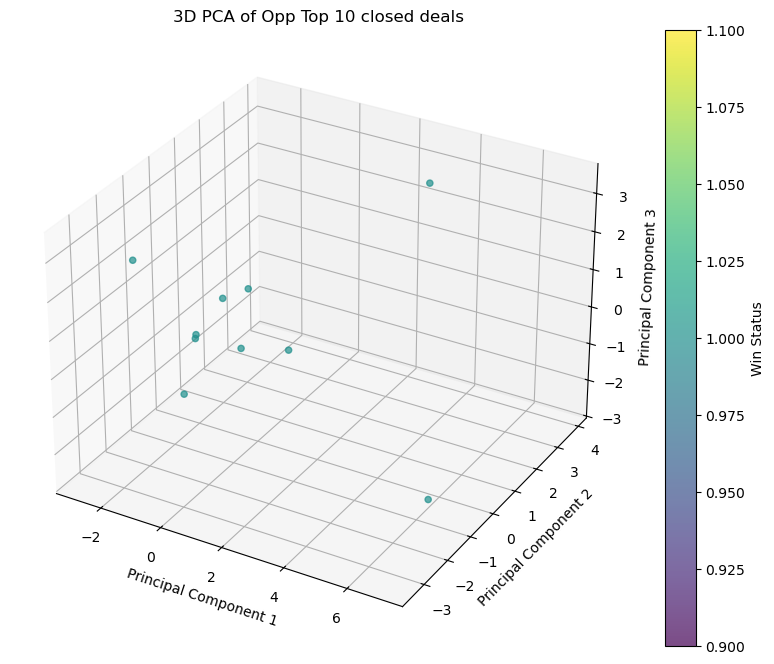

In [45]:
# Product flags and metrics
product_flags = ['a4_bw_flag', 'a4_c_flag', 'a3_bw_flag', 'a3_c_flag', 
                 'docuware_flag', 
                 'ms_flag', 'pp_bw_cs_flag', 'pp_c_cs_flag']
metrics = ['svc_calls', 'cv', 'renewal', 
           'employees_dnb', 'sales_dnb', 'web', 
            'hw', 'ms on', 'ps', 
           'supp', 'ts']

# One-hot encode categorical variables
categorical_col = ['customer_segment', 'crm_industry', 'sales_stage_status', 'funnel_stage']
top_10_closed_order_rev = pd.get_dummies(top_10_closed_order_rev, columns=categorical_col)

# Select features for PCA
data = top_10_closed_order_rev[product_flags + metrics]

# Scale features (excluding 'win'), win will be scaled as "nan"
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca = PCA(n_components=3)
pca_data = pca.fit_transform(data_scaled)

pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2', 'PC3'])

# Add 'win' back to the PCA DataFrame
pca_df['win'] = top_10_closed_order_rev['win'].values

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], 
                     c=pca_df['win'], cmap='viridis', alpha=0.7)

explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained Variance for 3 components: {explained_variance * 100:.2f}%")

components_df = pd.DataFrame(pca.components_, columns=product_flags + metrics)
print("Top contributing features for each component:\n", components_df)

plt.colorbar(scatter, label='Win Status')
ax.set_title('3D PCA of Opp Top 10 closed deals')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.show()

#### PC1:Negative contributionsa4_bw_flag, a4_c_flag, a3_bw_flag, and a3_c_flag.Positive contributions from docuware_flag, ms_flag, and svc_calls; PC2: positively include docuware_flag, ms_flag, and sales_dnb, with negative contributions from pp_c_cs_flag, employees_dnb, and web. PC3: Positive weights on a4_bw_flag, a4_c_flag, a3_bw_flag, a3_c_flag, and ms_flag, while negative weights are found in sales_dnb and web

Explained Variance for 3 components: 83.80%
Top contributing features for each component:
    a4_bw_flag  a4_c_flag  a3_c_flag  docuware_flag   ms_flag  pp_bw_cs_flag  \
0   -0.080702  -0.080702   0.236278       0.112418  0.028658       0.305424   
1   -0.171865  -0.171865   0.130641       0.510736  0.424859       0.252173   
2    0.593682   0.593682   0.443111       0.100443  0.013503       0.085049   

   svc_calls        cv  sales_dnb       web     ms on        ps      supp  \
0   0.383350  0.377287  -0.107254  0.104596  0.350069  0.361070  0.344065   
1  -0.047245  0.077191  -0.078230  0.488642 -0.253291 -0.120031 -0.255275   
2  -0.018798  0.007913  -0.263817  0.013454 -0.038019 -0.065517 -0.064007   

         ts  
0  0.375975  
1 -0.148656  
2 -0.034637  


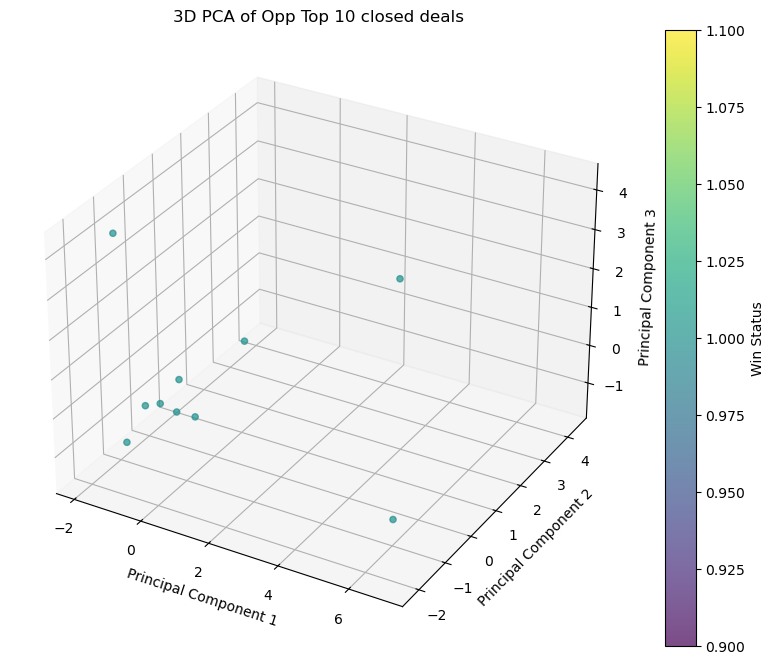

In [47]:
# Product flags and metrics
product_flags = ['a4_bw_flag', 'a4_c_flag', 'a3_c_flag', 
                 'docuware_flag', 
                 'ms_flag', 'pp_bw_cs_flag']
metrics = ['svc_calls', 'cv',  
            'sales_dnb', 'web', 
            'ms on', 'ps', 
           'supp', 'ts']

# One-hot encode categorical variables
categorical_col = ['customer_segment', 'crm_industry', 'sales_stage_status', 'funnel_stage']
top_10_closed_order_rev = pd.get_dummies(top_10_closed_order_rev, columns=categorical_col)

# Select features for PCA
data = top_10_closed_order_rev[product_flags + metrics]

# Scale features (excluding 'win'), win will be scaled as "nan"
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca = PCA(n_components=3)
pca_data = pca.fit_transform(data_scaled)

pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2', 'PC3'])

# Add 'win' back to the PCA DataFrame
pca_df['win'] = top_10_closed_order_rev['win'].values

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], 
                     c=pca_df['win'], cmap='viridis', alpha=0.7)

explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained Variance for 3 components: {explained_variance * 100:.2f}%")

components_df = pd.DataFrame(pca.components_, columns=product_flags + metrics)
print("Top contributing features for each component:\n", components_df)

plt.colorbar(scatter, label='Win Status')
ax.set_title('3D PCA of Opp Top 10 closed deals')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.show()

#### Component 1 highlights a mix of service interactions and product flags, likely representing customer engagement and service metrics.Component 2 focuses more on document and service management aspects along with web interactions, suggesting an emphasis on digital or document-related business processes.Component 3 revolves around product/service flags with some business size indicators, emphasizing characteristics related to print/document management and possibly sales-related factors.

In [67]:
oppo = opp[opp.has_opp == 1]
lead_cols = [col for col in oppo.columns if "lead" in col]
lead_cols.remove('lead')
oppo.drop(columns = lead_cols, inplace = True)

In [62]:
print(oppo.isna().sum())

key                          0
opportunity_number           0
quote_number            181584
order_number            327428
l2_rise_number               0
funnel_stage                 0
customer_segment             0
crm_industry                 0
a4_bw_flag                   0
a4_c_flag                    0
a3_bw_flag                   0
a3_c_flag                    0
docuware_flag                0
ransomcare_flag              0
it_health_check_flag         0
ms_flag                      0
pp_bw_cs_flag                0
pp_c_cs_flag                 0
wf_bw_flag                   0
wf_c_flag                    0
bw_lp_flag                   0
color_lp_flag                0
mfp_flag                     0
mindshift_flag               0
opp_date                     0
opp_rev                    851
quote_date              181584
quote_rev                    0
order_date              477949
order_rev                    0
close_date                  12
sales_stage_status           0
start_da

### PCA on opp number dataset: All numerica variables, except rev, date

Explained Variance for 3 components: 33.73%
Top contributing features for each component:
    a4_bw_flag  a4_c_flag  a3_bw_flag  a3_c_flag  docuware_flag  \
0    0.045118  -0.001720   -0.000459  -0.035255      -0.014987   
1    0.116621   0.008997   -0.012751  -0.103570      -0.028557   
2    0.007233   0.007730    0.055887  -0.002931      -0.003660   

   ransomcare_flag  it_health_check_flag   ms_flag  pp_bw_cs_flag  \
0        -0.007556             -0.006830 -0.006938      -0.014043   
1        -0.016462             -0.016640 -0.058843      -0.025416   
2        -0.006380             -0.000926  0.050474      -0.000690   

   pp_c_cs_flag       win  svc_calls        cv       mif   renewal       sat  \
0     -0.021245  0.072531   0.256078  0.017927  0.281179  0.148502  0.005671   
1     -0.043455  0.173782   0.365065  0.025655  0.364469  0.179561  0.068539   
2     -0.014733  0.016042  -0.084532 -0.018340 -0.053755  0.075105  0.692066   

        nps  employees_dnb  sales_dnb       we

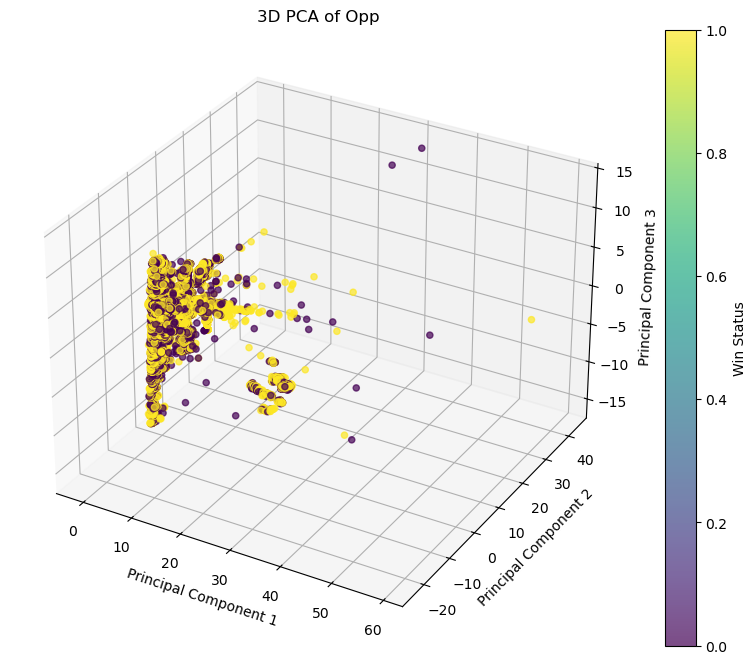

In [52]:
product_flags = ['a4_bw_flag', 'a4_c_flag', 'a3_bw_flag', 'a3_c_flag', 
                 'docuware_flag', 'ransomcare_flag', 'it_health_check_flag', 
                 'ms_flag', 'pp_bw_cs_flag', 'pp_c_cs_flag']
metrics = ['win', 'svc_calls', 'cv', 'mif', 'renewal', 'sat', 'nps', 
           'employees_dnb', 'sales_dnb', 'web', 'webinar', 
           'cs', 'hw', 'its', 'ms off', 'ms on', 'ps', 'refi', 'rent', 
           'supp', 'ts']

# categorical columns
categorical_col = ['customer_segment', 'crm_industry', 'sales_stage_status', 'funnel_stage']

# One-hot encode categorical variables
oppo = pd.get_dummies(oppo, columns=categorical_col)
data = oppo[product_flags + metrics]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca = PCA(n_components=3)
pca_data = pca.fit_transform(data_scaled)

explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained Variance for 3 components: {explained_variance * 100:.2f}%")

# Top contributing features 
components_df = pd.DataFrame(pca.components_, columns=product_flags + metrics)
print("Top contributing features for each component:\n", components_df)

pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2', 'PC3'])
pca_df['win'] = data['win']  # Color by 'win' to analyze win impact

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], 
                     c=pca_df['win'], cmap='viridis', alpha=0.7)

plt.colorbar(scatter, label='Win Status')
ax.set_title('3D PCA of Opp')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.show()

#### Less impactful variables: docuware_flag, ransomcare_flag, it_health_check_flag, a3_bw_flag, a3_c_flag pp_bw_cs_flag, and pp_c_cs_flag.

Explained Variance for 3 components: 43.39%
Top contributing features for each component:
    a4_bw_flag  a4_c_flag   ms_flag       win  svc_calls        cv       mif  \
0    0.043801  -0.002544 -0.005386  0.071313   0.254832  0.017799  0.279949   
1    0.112672   0.004367 -0.047784  0.174866   0.370906  0.025738  0.370472   
2    0.006324   0.007684  0.036974  0.007547  -0.083130 -0.018202 -0.052205   

    renewal       sat       nps  employees_dnb  sales_dnb       web   webinar  \
0  0.147742  0.005311  0.007198       0.322826   0.306692  0.224295  0.041571   
1  0.182374  0.068699  0.083890      -0.316558  -0.312132  0.242547 -0.030192   
2  0.071244  0.694250  0.693380       0.030180   0.024502 -0.050007  0.022213   

         cs        hw       its    ms off     ms on        ps      refi  \
0  0.013867  0.345322 -0.003480  0.034131  0.213130  0.373429  0.038245   
1 -0.016370 -0.299296 -0.003043 -0.019775  0.396769  0.119975  0.091517   
2  0.002407  0.036400 -0.003029 -0.027364 

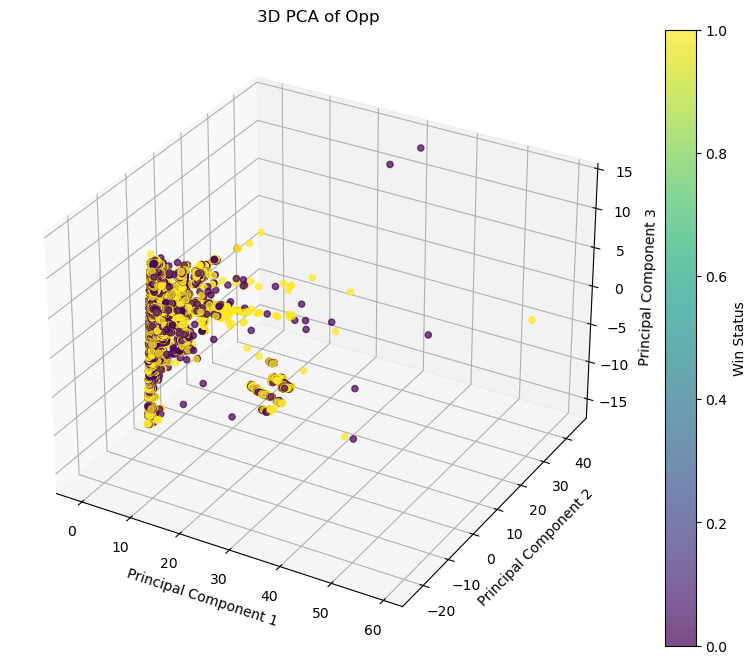

In [58]:
product_flags = ['a4_bw_flag', 'a4_c_flag', 
                 'ms_flag']
metrics = ['win', 'svc_calls', 'cv', 'mif', 'renewal', 'sat', 'nps', 
           'employees_dnb', 'sales_dnb', 'web', 'webinar', 
           'cs', 'hw', 'its', 'ms off', 'ms on', 'ps', 'refi', 'rent', 
           'supp', 'ts']

categorical_col = ['customer_segment', 'crm_industry', 'sales_stage_status', 'funnel_stage']

oppo = pd.get_dummies(oppo, columns=categorical_col)
data = oppo[product_flags + metrics]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca = PCA(n_components=3)
pca_data = pca.fit_transform(data_scaled)

explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained Variance for 3 components: {explained_variance * 100:.2f}%")

components_df = pd.DataFrame(pca.components_, columns=product_flags + metrics)
print("Top contributing features for each component:\n", components_df)

pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2', 'PC3'])
pca_df['win'] = data['win']  # Color by 'win' to analyze win impact

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], 
                     c=pca_df['win'], cmap='viridis', alpha=0.7)

plt.colorbar(scatter, label='Win Status')
ax.set_title('3D PCA of Opp')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

#### Less impactful: a4_bw_flag, a4_c_flag ms_flag, its,  cs, ps,refi, cv, renewal, ms_off, webinar and rent

Explained Variance for 3 components: 77.98%
Top contributing features for each component:
         win  svc_calls       mif       sat       nps  employees_dnb  \
0  0.056759   0.240234  0.265264 -0.000672  0.000040       0.383267   
1  0.188165   0.447852  0.438728  0.063550  0.078157      -0.261247   
2  0.005526  -0.060766 -0.039961  0.704114  0.701939       0.019886   

   sales_dnb       web        hw     ms on      supp        ts  
0   0.366765  0.221897  0.403459  0.188358  0.387156  0.435781  
1  -0.256998  0.305995 -0.241485  0.451578 -0.266343  0.016900  
2   0.015274 -0.045032  0.031481 -0.036431  0.034044  0.007066  


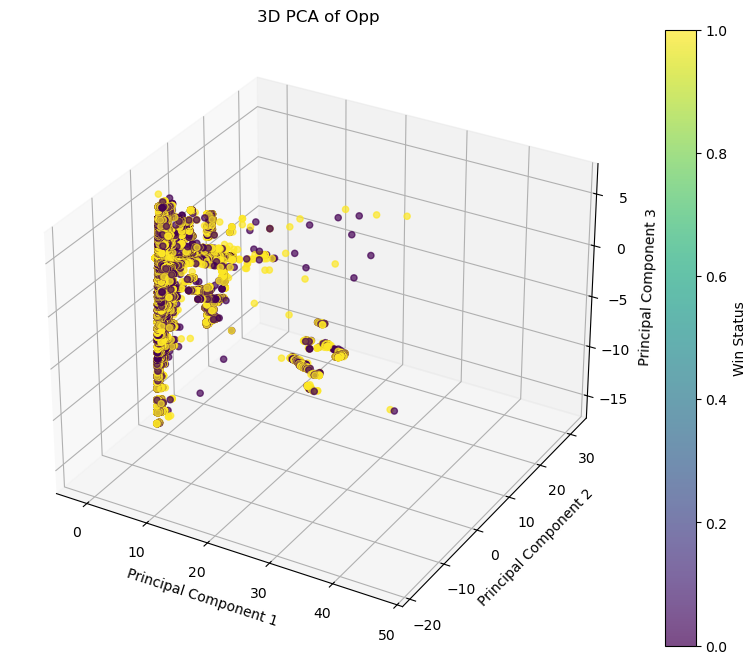

In [68]:
metrics = ['win', 'svc_calls', 'mif', 'sat', 'nps', 
           'employees_dnb', 'sales_dnb', 'web', 
            'hw', 'ms on',  
           'supp', 'ts']

categorical_col = ['customer_segment', 'crm_industry', 'sales_stage_status', 'funnel_stage']

oppo = pd.get_dummies(oppo, columns=categorical_col)
data = oppo[metrics]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca = PCA(n_components=3)
pca_data = pca.fit_transform(data_scaled)

explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained Variance for 3 components: {explained_variance * 100:.2f}%")

components_df = pd.DataFrame(pca.components_, columns=metrics)
print("Top contributing features for each component:\n", components_df)

pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2', 'PC3'])
pca_df['win'] = data['win']  # Color by 'win' to analyze win impact

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], 
                     c=pca_df['win'], cmap='viridis', alpha=0.7)

plt.colorbar(scatter, label='Win Status')
ax.set_title('3D PCA of Opp')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

#### svc_calls, mif, sales_dnb, win (these variables seem to form a correlated group across the first two components).Sat and nps (both linked in PC3). Employees_dnb and sales_dnb (indicating a link between business size and sales metrics).

### Try Marketing engagement metrics with one-hot encode categorical Variables

Explained Variance for 3 components: 66.59%
Top contributing features for each component:
    svc_calls        cv       mif   renewal       sat       nps       web  \
0   0.562145  0.043539  0.579397  0.293289  0.078732  0.091523  0.490776   
1  -0.095014 -0.014427 -0.071523  0.056016  0.699436  0.697581 -0.081676   
2  -0.174578  0.033310 -0.149054  0.096555  0.006696 -0.035510  0.184814   

    webinar  
0  0.070307  
1  0.003166  
2  0.949427  


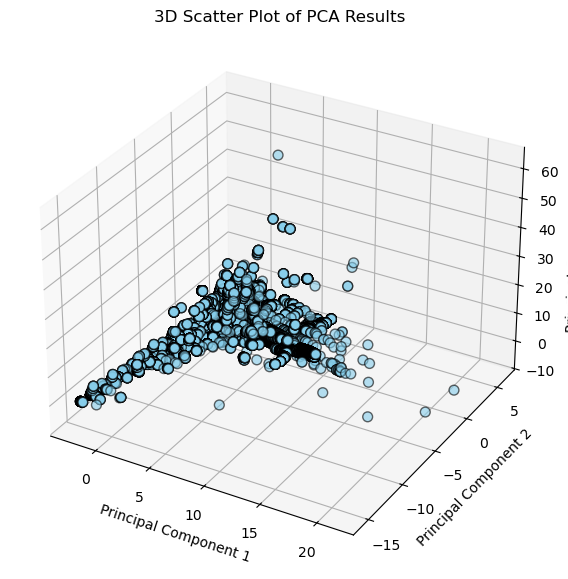

In [54]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

categorical_cols = ['customer_segment', 'crm_industry', 'sales_stage_status', 'funnel_stage']
oppo = pd.get_dummies(oppo, columns=categorical_cols)

numeric_cols = ['svc_calls', 'cv', 'mif', 'renewal','sat', 'nps', 'web','webinar']
data_numeric = oppo[numeric_cols]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

pca = PCA(n_components=3)
pca_data = pca.fit_transform(data_scaled)

explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained Variance for 3 components: {explained_variance * 100:.2f}%")

components_df = pd.DataFrame(pca.components_, columns=numeric_cols)
print("Top contributing features for each component:\n", components_df)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c='skyblue', s=50, alpha=0.6, edgecolor='k')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title("3D Scatter Plot of PCA Results")
plt.show()

### Compare top 10 closed order_rev deals and opportunity data. Similarities: svc_calls(customer interaction), sales_dnb, web, ms on, ps, supp, ts(engagement metrics); Differences:Product-specific flags such as a4_bw_flag, a4_c_flag, a3_c_flag, docuware_flag, and pp_bw_cs_flag that might play a role in finalizing high-value deals;sat, nps and employees_dnb also important be indicative of the size or type of businesses that tend to generate the most opportunities or close deals.